In [1]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')
df.head()

,domain,url,published_date
0,medium.com,https://medium.com/policy/medium-terms-of-serv...,2012-08-13
1,medium.com,https://medium.com/policy/medium-privacy-polic...,2012-08-13
2,medium.com,https://medium.com/@Medium/personalize-your-me...,2016-11-04
3,medium.com,https://medium.com/holiday-poems/xmas-morning-...,2016-12-24
4,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...,2015-09-22


In [2]:
df_by_day = df['published_date'].value_counts().sort_index()
df_by_day = df_by_day.to_frame()
df_by_day['ds'] = df_by_day.index
df_by_day.rename(columns={"published_date":"y"}, inplace=True)
df_by_day.head()

,y,ds
1970-01-01,2,1970-01-01
1970-01-18,3,1970-01-18
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16


In [3]:
df_by_day = df_by_day.iloc[2:]
df_by_day.head()

,y,ds
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16
2005-09-12,1,2005-09-12
2006-02-19,1,2006-02-19


19:48:25 - cmdstanpy - INFO - Chain [1] start processing
19:48:25 - cmdstanpy - INFO - Chain [1] done processing


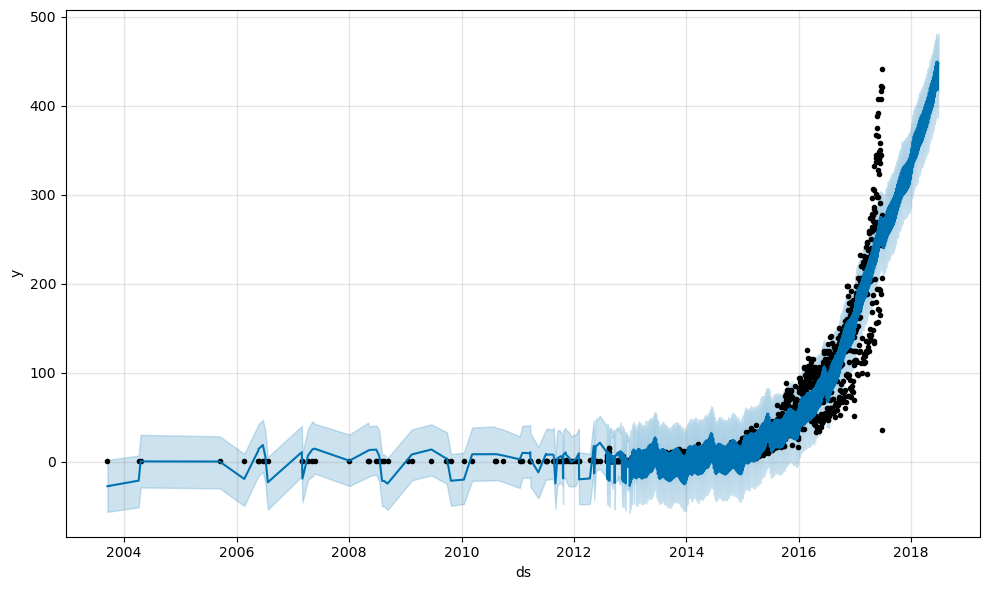

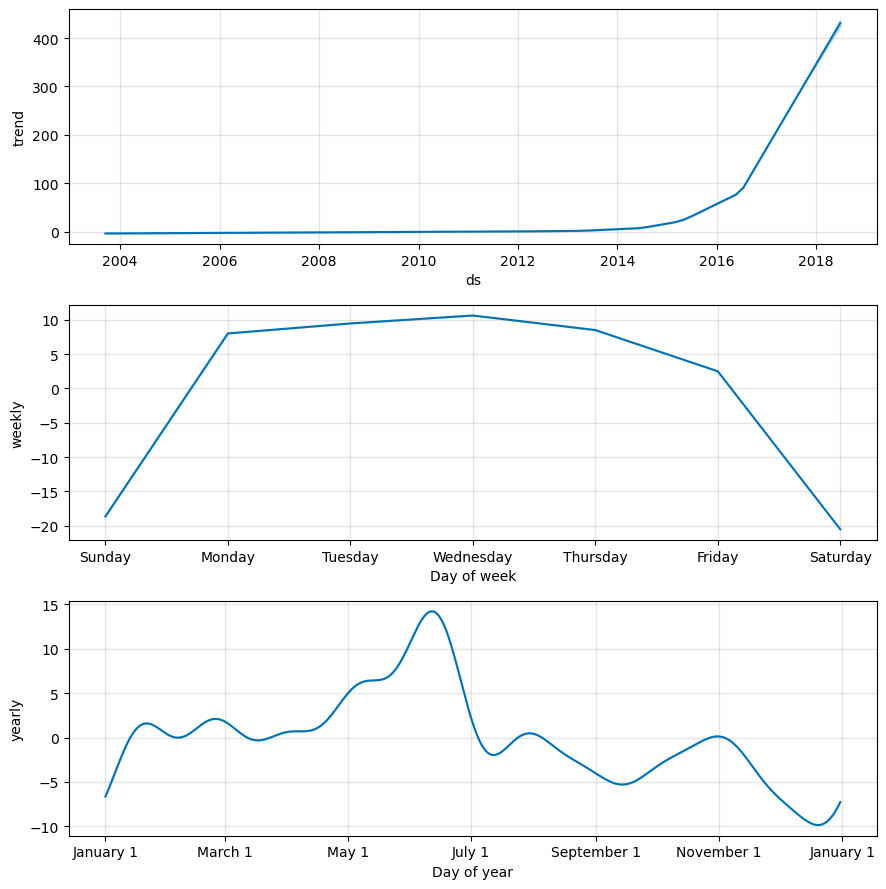

In [4]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
m = Prophet()
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

  0%|          | 0/22 [00:00<?, ?it/s]

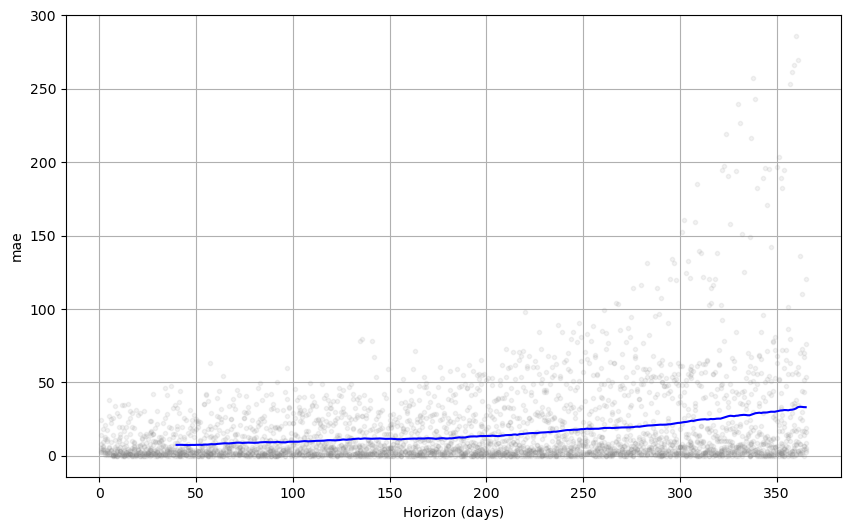

In [5]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Standard tuning

In [6]:
from common import *

tuning_results = tune_gridsearch(df_by_day)
tuning_results.head()

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mae,mape
198,0.5,0.01,0.10,multiplicative,0.80,27.723428,13.362756,0.435541
194,0.5,0.01,0.01,multiplicative,0.80,27.723428,13.362756,0.435541
202,0.5,0.01,1.00,multiplicative,0.80,27.723428,13.362756,0.435541
206,0.5,0.01,10.00,multiplicative,0.80,27.723428,13.362756,0.435541
223,0.5,0.10,10.00,multiplicative,0.95,28.537553,13.978967,0.383156


## Second version of tuning - Optuna

In [7]:
tune_optuna(df_by_day)

[I 2023-03-11 19:56:58,015] A new study created in memory with name: no-name-a6f51a18-3199-495f-9f2e-adf8d9120b43
/home/jsowa/work/prophet/common.py:82: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


Best trial:
   mae :  12.579349761834836
  Params: 
    changepoint_prior_scale: 0.8364682437675819
    seasonality_prior_scale: 0.018897399134504764
    holidays_prior_scale: 0.43070675471518904
    seasonality_mode: multiplicative
    changepoint_range: 0.8668281827058872
